#라이브러리

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2, glob, tqdm, time
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


#데이터셋 설정

In [15]:
path_x = '/content/drive/MyDrive/data/slices/train/img/img/'
path_y = '/content/drive/MyDrive/data/slices/train/mask/img/'
path_test = '/content/drive/MyDrive/data/slices/eval/img/'

img_height = 400
img_width = 400

In [17]:
x_list = sorted(glob.glob(path_x+'*'))
y_list = sorted(glob.glob(path_y+'*'))

train_x,valid_x = train_test_split(x_list,test_size=0.2,random_state=1000)
train_y,valid_y = train_test_split(y_list,test_size=0.2,random_state=1000)
test_x = sorted(glob.glob(path_test+'*'))

print(len(train_x),len(train_y))
print(len(valid_x),len(valid_y))

448 448
112 112


In [4]:
class Custom_Dataset(Dataset):
    
    def __init__(self, x_list, y_list):
        self.x_list = x_list
        self.y_list = y_list
        
    def __len__(self):
        return len(self.x_list)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.x_list[idx],cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img,(img_width,img_height))
        img = np.expand_dims(img,-1)
        img = img / 255.0
        img = img.astype(np.float32)
        img = torch.from_numpy(img)
        img = torch.permute(img,(2,0,1))

        mask = cv2.imread(self.y_list[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask,(img_width,img_height))
        mask = np.expand_dims(mask,-1)
        mask = mask / 255.0
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)
        mask = torch.permute(mask,(2,0,1))

        return img, mask
train_set = Custom_Dataset(train_x, train_y)
val_set = Custom_Dataset(valid_x, valid_y)

In [5]:
ds = iter(train_set)

In [ ]:
ds = iter(train_set)
for i in range(2):
    img, mask = next(ds)
    plt.figure(figsize=(15,15))
    plt.subplot(1, 2, 1)
    plt.imshow(img[0].cpu(),cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(mask[0].cpu(),cmap='gray')
    plt.show()

#모델구현

In [7]:


class UNet(nn.Module):
    def __init__(self):
        super(UNet,self).__init__()
        def cbr(in_channels, out_channels, kernel_size = 3, stride = 1):
            layers = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size,stride,1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
            return layers
        
        self.enc1_1 = cbr(1,64)
        self.enc1_2 = cbr(64,64)
        self.pool1 = nn.MaxPool2d(2,2)
        
        self.enc2_1 = cbr(64,128)
        self.enc2_2 = cbr(128,128)
        self.pool2 = nn.MaxPool2d(2,2)

        self.enc3_1 = cbr(128,256)
        self.enc3_2 = cbr(256,256)
        self.pool3 = nn.MaxPool2d(2,2)

        self.enc4_1 = cbr(256,512)
        self.enc4_2 = cbr(512,512)
        self.pool4 = nn.MaxPool2d(2,2)

        self.enc5_1 = cbr(512,1024)
        self.enc5_2 = cbr(1024,1024)

        self.unpool4 = nn.ConvTranspose2d(1024,512,2,2)
        self.dec4_2 = cbr(1024,512)
        self.dec4_1 = cbr(512,512)

        self.unpool3 = nn.ConvTranspose2d(512,256,2,2)
        self.dec3_2 = cbr(512,256)
        self.dec3_1 = cbr(256,256)

        self.unpool2 = nn.ConvTranspose2d(256,128,2,2)
        self.dec2_2 = cbr(256,128)
        self.dec2_1 = cbr(128,128)

        self.unpool1 = nn.ConvTranspose2d(128,64,2,2)
        self.dec1_2 = cbr(128,64)
        self.dec1_1 = cbr(64,64)

        self.result = nn.Sequential(
            nn.Conv2d(64,1,3,1,1),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        
        enc1_1 = self.enc1_1(x) 
        enc1_2 = self.enc1_2(enc1_1) 
        pool1 = self.pool1(enc1_2) 
        
        enc2_1 = self.enc2_1(pool1) 
        enc2_2 = self.enc2_2(enc2_1) 
        pool2 = self.pool2(enc2_2) 
        
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1) 
        pool3 = self.pool3(enc3_2)        
        
        enc4_1 = self.enc4_1(pool3) 
        enc4_2 = self.enc4_2(enc4_1) 
        pool4 = self.pool4(enc4_2) 
        
        enc5_1 = self.enc5_1(pool4) 
        enc5_2 = self.enc5_2(enc5_1) 
        
        unpool4 = self.unpool4(enc5_2)
        dec4_2 = self.dec4_2(torch.cat((unpool4,enc4_2),1))
        dec4_1 = self.dec4_1(dec4_2) 
        
        unpool3 = self.unpool3(dec4_1) 
        dec3_2 = self.dec3_2(torch.cat((unpool3,enc3_2),1)) 
        dec3_1 = self.dec3_1(dec3_2) 
        
        unpool2 = self.unpool2(dec3_1) 
        dec2_2 = self.dec2_2(torch.cat((unpool2,enc2_2),1)) 
        dec2_1 = self.dec2_1(dec2_2) 
        
        unpool1 = self.unpool1(dec2_1) 
        dec1_2 = self.dec1_2(torch.cat((unpool1,enc1_2),1))
        dec1_1 = self.dec1_1(dec1_2) 

        out = self.result(dec1_1)
        return out 


#학습지표 설정

In [9]:
def mIoU(pred,true,eps=1e-5):
    with torch.no_grad():
        intersection = torch.sum(true * pred) 
        union = torch.sum(true) + torch.sum(pred) - intersection
        iou = (intersection+ eps) / (union +eps) 
    return iou

def accuracy(pred,true):
    with torch.no_grad():
        batch = len(pred)
        p = pred.clone().detach()
        p[p>=0.5] = 1
        p[p<0.5] = 0
        correct = torch.sum(true == p) 
        accuracy = correct / (pred.size(2)*pred.size(3)*batch)
    return accuracy

#학습

In [ ]:
model = UNet()
model = model.to(device)
criterion = nn.BCELoss()
max_lr = 1e-3
epochs = 50
optimizer = torch.optim.Adam(model.parameters(),lr=max_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch)

model_save_path = './Best.pt'

batch_size = 8
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)   

In [ ]:
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
lrs = []
min_epoch = 0
fit_time = time.time()


for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    running_valid_loss = 0.0

    running_train_acc = 0.0
    running_valid_acc = 0.0

    lrs.append(optimizer.param_groups[0]['lr'])

    progress_train = tqdm.tqdm(train_loader,desc=f'Epoch:{epoch+1}/{epochs}')
    for i,data in enumerate(progress_train):
        img,mask = data
        optimizer.zero_grad()
        img = img.to(device)
        mask = mask.to(device)


        pred = model(img)
        loss = criterion(pred, mask)
        acc = accuracy(pred,mask)

        loss.backward()
        optimizer.step() 
        
        running_train_loss += loss
        running_train_acc += acc
        progress_train.set_description(f'Epoch:{epoch+1}/{epochs} | Train_Acc:{running_train_acc/(i+1):.4f} | Train_Loss:{running_train_loss/(i+1):.4f}')

    model.eval()
    with torch.no_grad():
        progress_valid = tqdm.tqdm(val_loader,desc=f'Epoch:{epoch+1}/{epochs}')
        for i, data in enumerate(progress_valid):
            img.mask = data
            
            img = img.to(device)
            mask = mask.to(device)
            
            
            pred = model(img)
            acc = accuracy(pred,mask)
            loss = criterion(pred, mask)          

            running_valid_loss += loss
            running_valid_acc += acc
            progress_valid.set_description(f'Epoch:{epoch+1}/{epochs} | Valid_Acc:{running_valid_acc/(i+1):.4f} | Valid_Loss:{running_valid_loss/(i+1):.4f}') 

    scheduler.step()
    train_losses.append((running_train_loss/len(train_loader)).detach().cpu().numpy())
    valid_losses.append((running_valid_loss/len(val_loader)).detach().cpu().numpy())
    train_accs.append((running_train_acc/len(train_loader)).detach().cpu().numpy())
    valid_accs.append((running_valid_acc/len(val_loader)).detach().cpu().numpy())

    if valid_losses[min_epoch] >= valid_losses[epoch]:
        print(f'Valid Loss가 최소가 됐습니다. ({valid_losses[min_epoch]:.4f}({min_epoch+1}) -> {valid_losses[epoch]:.4f}({epoch+1})')
        print(f'해당 모델이 {model_save_path} 경로에 저장됩니다.')
        min_epoch = epoch
        torch.save(model, model_save_path)
    else:
        print(f'Valid_Loss가 최소가 되지 못했습니다.(최소 Epoch:{min_epoch+1} : {valid_losses[min_epoch]:.4f})')
    print('')
            


    
print('학습 최종 시간: {:.2f} 분\n' .format((time.time()- fit_time)/60))

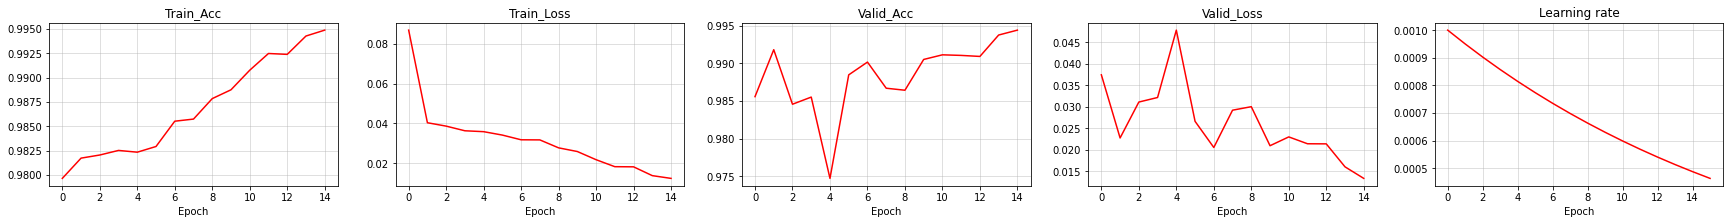

In [11]:
plt.figure(figsize=(30,3))

plt.subplot(1,5,1)
plt.xlabel('Epoch')
plt.plot(train_accs,'r-')
plt.title('Train_Acc')
plt.grid(True, axis='both',alpha=0.5)

plt.subplot(1,5,2)
plt.xlabel('Epoch')
plt.plot(train_losses,'r-')
plt.title('Train_Loss')
plt.grid(True, axis='both',alpha=0.5)

plt.subplot(1,5,3)
plt.xlabel('Epoch')
plt.plot(valid_accs,'r-')
plt.title('Valid_Acc')
plt.grid(True, axis='both',alpha=0.5)

plt.subplot(1,5,4)
plt.xlabel('Epoch')
plt.plot(valid_losses,'r-')
plt.title('Valid_Loss')
plt.grid(True, axis='both',alpha=0.5)

plt.subplot(1,5,5)
plt.xlabel('Epoch')
plt.plot(lrs,'r-')
plt.title('Learning rate')
plt.grid(True, axis='both',alpha=0.5)
plt.show()

#학습결과 사용

In [12]:
def pred_test(path,threshold=True):
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img = img/255.0
    img = np.expand_dims(img,-1)
    img = np.expand_dims(img,0)
    img = img.astype(np.float32)

    img = torch.from_numpy(img)
    img = torch.permute(img,(0,3,1,2))
    img = img.to(device)

    pred = model(img).to(device)
    pred = torch.permute(pred,(0,2,3,1))
    pred = pred.detach().cpu()
    if threshold:
        pred[pred>=0.5] = 1
        pred[pred<0.5] = 0

    img = torch.permute(img,(0,2,3,1))
    img = img.cpu()

    return img,pred


In [ ]:
for path in tqdm.tqdm(test_x):
    img ,mask = pred_test(path)

    plt.figure(figsize=(15,15))
    plt.subplot(1, 2, 1)
    plt.imshow(img[0,:,:,0],cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(mask[0,:,:,0],cmap='gray')
    plt.show()

#모델사용

In [ ]:
model = torch.load('./Best.pt')
model.eval()